In [1]:
import collections
import inspect

import numpy as np
import pandas as pd
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
plt.style.use('ggplot')

import litholog
from litholog import utils
from litholog.sequence import io, BedSequence

In [2]:
transforms = {c : utils.string2array_pandas for c in ['depth_m', 
                                                      'grain_size_mm', 
                                                      'grain_size_psi']}

beds = pd.read_csv('../data/AllBedsWithProfiles_2020July_with_psi.csv', 
                   converters=transforms)

In [3]:
beds.columns

Index(['name', 'count', 'collection', 'eod', 'eodnum', 'tops', 'th',
       'gs_tops_mm', 'gs_tops_psi', 'snd_shl', 'mean_gs_mm', 'mean_gs_psi',
       'max_gs_mm', 'max_gs_psi', 'ng', 'ar', 'depth_m', 'grain_size_mm',
       'grain_size_psi'],
      dtype='object')

In [4]:
beds.head()

,name,count,collection,eod,eodnum,tops,th,gs_tops_mm,gs_tops_psi,snd_shl,mean_gs_mm,mean_gs_psi,max_gs_mm,max_gs_psi,ng,ar,depth_m,grain_size_mm,grain_size_psi
0,Marnoso 1,1,Marnoso-Arenacea,basin plain,0,22.81684,0.31082,0.115051,-3.1197,1.0,0.116073,-3.1069,0.117046,-3.0948,0.520514,0.021978,"[22.8168, 22.703, 22.5337, 22.506]","[0.1151, 0.1157, 0.117, 0.117]","[-3.119, -3.1115, -3.0954, -3.0954]"
1,Marnoso 1,1,Marnoso-Arenacea,basin plain,0,22.50602,0.60931,0.001000,-9.9658,0.0,0.001000,-9.9658,0.001000,-9.9658,0.520514,0.021978,"[22.506, 21.8967]","[0.001, 0.001]","[-9.9658, -9.9658]"
2,Marnoso 1,1,Marnoso-Arenacea,basin plain,0,21.89671,0.10463,0.125380,-2.9956,1.0,0.125380,-2.9956,0.125380,-2.9956,0.520514,0.021978,"[21.8967, 21.7921]","[0.1254, 0.1254]","[-2.9954, -2.9954]"
3,Marnoso 1,1,Marnoso-Arenacea,basin plain,0,21.79208,0.11694,0.001000,-9.9658,0.0,0.001000,-9.9658,0.001000,-9.9658,0.520514,0.021978,"[21.7921, 21.6751]","[0.001, 0.001]","[-9.9658, -9.9658]"
4,Marnoso 1,1,Marnoso-Arenacea,basin plain,0,21.67514,0.13232,0.134306,-2.8964,1.0,0.150073,-2.7363,0.160420,-2.6401,0.520514,0.021978,"[21.6751, 21.6351, 21.5674, 21.5428]","[0.1343, 0.1447, 0.1604, 0.1604]","[-2.8965, -2.7889, -2.6403, -2.6403]"


## Separate demo logs

In [5]:
demo_names = ['Pukearuhue', 'Magnolia', 'Karoo krf']

METACOLS = ['name', 'count', 'collection', 'eod', 'eodnum', 'ng', 'ar']
DATACOLS = ['th','gs_tops_mm', 'snd_shl', 'depth_m',
            'gs_tops_mm', 'mean_gs_mm', 'max_gs_mm', 'grain_size_mm',
            'gs_tops_psi', 'mean_gs_psi', 'max_gs_psi', 'grain_size_psi']

seqs = []
for name, seq_df in beds.groupby('name'):
    if any([n in name for n in demo_names]):
        seqs.append(BedSequence.from_dataframe(
            seq_df, thickcol='th',
            component_map=litholog.defaults.DEFAULT_COMPONENT_MAP,
            metacols=METACOLS,
            datacols=DATACOLS,
        ))

In [6]:
len(seqs), [(s.metadata['name'], len(s)) for s in seqs]

(19,
 [('Karoo krf1', 105),
  ('Karoo krf10', 221),
  ('Karoo krf11', 47),
  ('Karoo krf12', 35),
  ('Karoo krf13', 51),
  ('Karoo krf14', 96),
  ('Karoo krf15', 54),
  ('Karoo krf16', 167),
  ('Karoo krf17', 97),
  ('Karoo krf2', 20),
  ('Karoo krf3', 42),
  ('Karoo krf4', 15),
  ('Karoo krf5', 51),
  ('Karoo krf6', 288),
  ('Karoo krf7', 205),
  ('Karoo krf8', 244),
  ('Karoo krf9', 191),
  ('Magnolia', 180),
  ('Pukearuhue', 209)])

# Plotting utilities

### Stealing some functions from `depstrat`

In [7]:

def suggest_figsize(sequence, aspect=10):
    """
    Defining default a total thickness -> figure size mapping.
    """
    suggest_h = max(10, min(sequence.cum, 50))
    suggest_w = suggest_h / aspect
    return (suggest_w, suggest_h)


def strip_fig_extra_columns(sequence, ncols, exxon_style=True, figsize=None, aspect=10):
    """
    Creates a fig with `ncol` axes and plots `sequence` on one of them.
    If `exxon_style`, plots `sequence` on first axis, otherwise last axis.
    Returns
    -------
    fig, ax
    """
    w, h = suggest_figsize(sequence, aspect=aspect)
    print(w, h)

    fig, ax = plt.subplots(ncols=ncols, sharey=True, figsize=(w*ncols, h))
    #fig.subplots_adjust(wspace=0.)

    sequence.plot(legend=litholog.defaults.litholegend,
                  width_field='grain_size_psi',
                  depth_field='depth_m',
                  ax=ax[0])

    return fig, ax


def gradient_fill(x, y, ax, pos_or_neg,
                  fill_color=None,
                  **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.
    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    ax : a matplotlib Axes instance
        The axes to plot on.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.
    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    x[np.argwhere(np.isnan(x))] = 0.

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    if pos_or_neg=='positive':
        alpha_gradient = np.linspace(0.2, alpha, 100)
        xmin, xmax = 0., ax.get_xlim()[1]
    else:
        alpha_gradient = np.linspace(alpha, 0.2, 100)
        xmin, xmax = ax.get_xlim()[0], 0.

    z = np.empty((1, 100, 4), dtype=float)
    z[:,:,-1] = alpha_gradient[None,:]

    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb

    ymin, ymax = y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.flipud(xy) if y[0] < y[1] else xy   # Have to flip order for 'depth'-ordered striplogs
    if pos_or_neg=='positive':
        xy = np.vstack([[xmin, ymax], xy, [xmin, ymin], [xmin, ymax]])
    else:
        xy = np.vstack([[xmax, ymax], xy, [xmax, ymin], [xmax, ymax]])

    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    #ax.autoscale(True)
    return line, im

# Plotting with convolution "gamma ray"

2.338050702353454 21.042456321181085
Set_ylim:  [0.0, 21.042456321181106]


(<matplotlib.lines.Line2D at 0x7fe42250de90>,
 <matplotlib.image.AxesImage at 0x7fe4225c7ad0>)

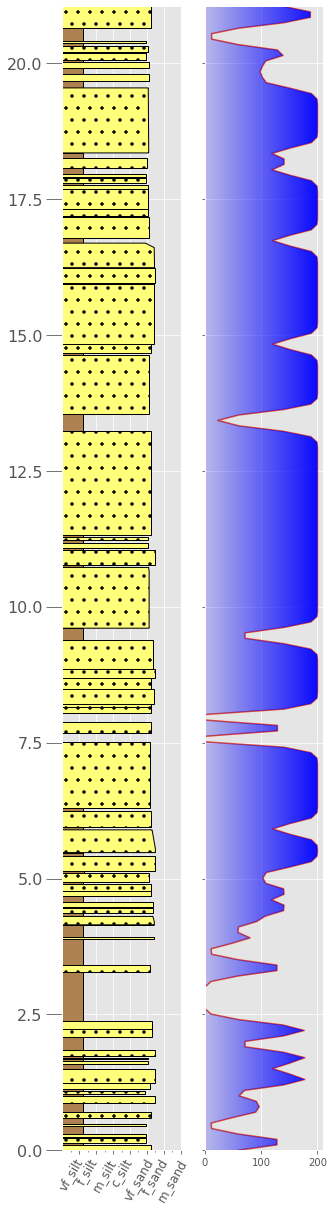

In [8]:
# using astropy.convolve for now

def pseudo_gamma(seq):
    # Params that will be args in the API:
        
    gs_threshold = 0.016   # Cutoff in mm
    gamma_range = (0, 200) # Low/High values
    resolution = 0.1       # Depth resolution
    sigma = 1              # Gaussian filter width
    
    ds, gs = seq.get_field('depth_m'), seq.get_field('grain_size_mm')
    
    # Needs to be increasing for `np.interp`
    if ds[0] > ds[-1]:
        ds, gs = ds[::-1], gs[::-1]
    
    # Resampling
    nsamples = np.abs(ds[0]-ds[-1]) // resolution + 1
    resampled_ds = np.linspace(ds[0], ds[-1], num=int(nsamples), endpoint=True)
    resampled_gs = np.interp(resampled_ds, ds, gs)
    
    # Thresholding gs -> GR
    nan_idxs = np.argwhere(np.isnan(resampled_gs))
    resampled_gs[nan_idxs] = gamma_range[0]
    sample_gr = np.where(resampled_gs < gs_threshold, gamma_range[0], gamma_range[1])
    
    # Gauss filter
    # using astropy.convolve for now
    kernel = Gaussian1DKernel(sigma) # divided by resolution?
    conv_gr = convolve(sample_gr, kernel)
    conv_gr[nan_idxs] = np.nan
    
    return resampled_ds, conv_gr


fig, ax = strip_fig_extra_columns(seqs[0], 2, aspect=9)

ds, gr = pseudo_gamma(seqs[0])
gradient_fill(gr, ds, ax[1], 'positive', fill_color='b')